In [ ]:
pip install timm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import time
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from sklearn.metrics import roc_auc_score,roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [ ]:
num_classes=13
batch_size=32
learning_rate=1e-5
num_epochs=15

In [ ]:
transforms=transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

In [ ]:
train_dataset=datasets.ImageFolder(root='/content/drive/MyDrive/CSE 507/chestswin/train',transform=transforms)
test_dataset=datasets.ImageFolder(root='/content/drive/MyDrive/CSE 507/chestswin/test',transform=transforms)
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [ ]:
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False)

In [ ]:
model.head=nn.Linear(model.head.in_features,num_classes)

In [ ]:
model.head.in_features

768

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.AdamW(model.parameters(),lr=learning_rate)

In [ ]:
for epochs in range(num_epochs):
  model.train()
  running_loss=0.0
  for images,labels in train_loader:


    outputs=model(images)
    outputs = outputs.view(outputs.size(0), -1)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss=running_loss+loss.item()
    optimizer.zero_grad()


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CSE 507/swin_tiny_data_cleaned.pth')

In [ ]:
model.eval()
correct=0
total=0
all_labels=[]
all_preds=[]

In [ ]:
with torch.no_grad():
  for images, labels in test_loader:
    outputs=model(images)
    outputs=outputs.view(outputs.size(0),-1,outputs.size(-1))
    outputs=outputs.mean(dim=1)
    probabilities=nn.Softmax(dim=1)(outputs)
    _,predicted=torch.max(outputs.data,1)
    all_labels.append(labels)
    all_preds.append(probabilities.cpu().numpy())
    total=total+labels.size(0)
    correct=correct+(predicted==labels).sum().item()

all_labels=np.concatenate(all_labels)
all_preds=np.concatenate(all_preds)
all_labels_onehot=np.zeros((all_labels.size,num_classes))
all_labels_onehot[np.arange(all_labels.size),all_labels]=1
auc=roc_auc_score(all_labels_onehot,all_preds,multi_class='ovr')

print(f"Accuracy of the model on the test images:{100*correct/total}%")
print(f"AUC Score:{auc:.4f}")


Accuracy of the model on the test images:8.796947178148223%
AUC Score:0.5522


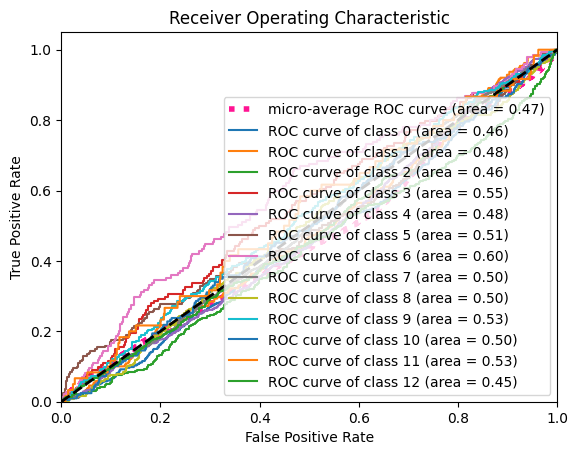

In [ ]:
def plot_roc_curve(model, dataloader, num_classes):

    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)


            outputs = outputs.view(outputs.size(0), -1, outputs.size(-1))
            outputs = outputs.mean(dim=1)

            probabilities = torch.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    y_true = label_binarize(y_true, classes=np.arange(num_classes))

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(model, test_loader, num_classes)